# ResNet Architecture: Skip Connections and Their Benefits

This notebook explores the **ResNet Architecture**, focusing on the use of **skip connections** and their benefits. ResNet (Residual Network) is a deep learning architecture designed to address the problem of vanishing gradients in very deep neural networks.

## Why Skip Connections?
- Skip connections allow the model to learn residual mappings instead of directly learning the target function.
- They help gradients flow through the network during backpropagation, mitigating the vanishing gradient problem.
- Skip connections enable the training of very deep networks, improving accuracy on complex tasks.

In [6]:
# Import necessary libraries
from tensorflow.keras.utils import plot_model
from ASCAD_train_models import resnet_v1

# Create a ResNet model
resnet_model = resnet_v1(input_shape=(700, 1), depth=19, num_classes=256)

# Save the architecture diagram
plot_model(resnet_model, to_file="resnet_architecture.png", show_shapes=True, show_layer_names=True)

# Display the architecture diagram
from IPython.display import Image
Image(filename="resnet_architecture.png")

You must install pydot (`pip install pydot`) for `plot_model` to work.


## Benefits of Skip Connections

1. **Mitigating Vanishing Gradients**:
   - Skip connections allow gradients to flow directly through the network, bypassing intermediate layers.
   - This helps prevent the gradients from becoming too small as they propagate backward through the network.

2. **Improved Training of Deep Networks**:
   - Without skip connections, very deep networks often suffer from degradation (accuracy saturates or decreases).
   - Skip connections enable the training of networks with hundreds of layers.

3. **Faster Convergence**:
   - By learning residual mappings, the network converges faster during training.

4. **Better Generalization**:
   - ResNet models often generalize better to unseen data compared to traditional deep networks.

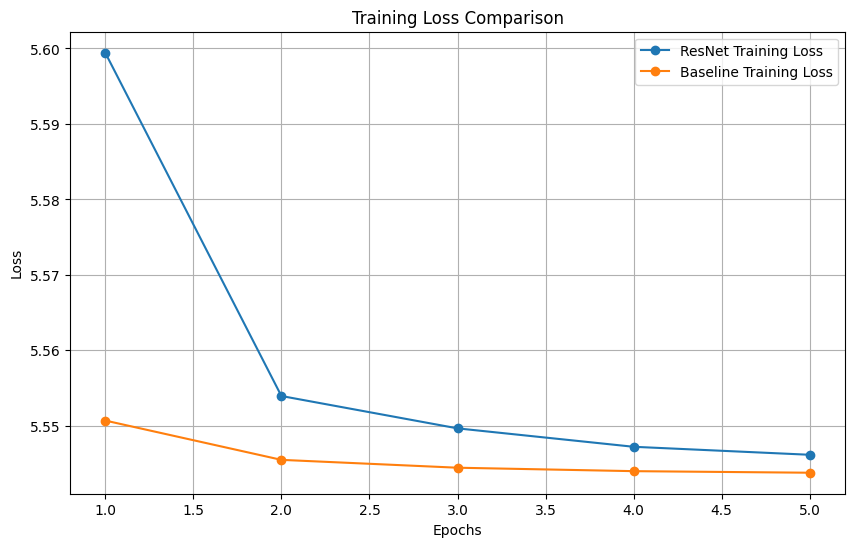

In [14]:
# Import necessary libraries
import pickle
import matplotlib.pyplot as plt

# Paths to the history files
history_resnet_path = "ATMEGA_AES_v1/ATM_AES_v1_fixed_key/ASCAD_data/ASCAD_trained_models/my_cnn_best_dropout_desync0_epochs5_batchsize200_history.pkl"
history_baseline_path = "ATMEGA_AES_v1/ATM_AES_v1_fixed_key/ASCAD_data/ASCAD_trained_models/my_cnn_best_no_bn_desync0_epochs5_batchsize200_history.pkl"

# Load the history files
with open(history_resnet_path, "rb") as f:
    history_resnet = pickle.load(f)

with open(history_baseline_path, "rb") as f:
    history_baseline = pickle.load(f)

# Extract training loss
epochs = range(1, len(history_resnet['loss']) + 1)
loss_resnet = history_resnet['loss']
loss_baseline = history_baseline['loss']

# Plot training loss curves
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss_resnet, label='ResNet Training Loss', marker='o')
plt.plot(epochs, loss_baseline, label='Baseline Training Loss', marker='o')
plt.title('Training Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

In [ ]:
# ResNet implementation from ASCAD_train_models.py
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, Activation, Add, AveragePooling1D, Flatten, Dense
from tensorflow.keras.models import Model

def resnet_layer(inputs, num_filters=16, kernel_size=11, strides=1, activation='relu', batch_normalization=True):
    """A single ResNet layer with optional batch normalization."""
    x = Conv1D(num_filters, kernel_size=kernel_size, strides=strides, padding='same', kernel_initializer='he_normal')(inputs)
    if batch_normalization:
        x = BatchNormalization()(x)
    if activation:
        x = Activation(activation)(x)
    return x

def resnet_v1(input_shape, depth, num_classes=256):
    """Builds a ResNet v1 model."""
    if (depth - 1) % 18 != 0:
        raise ValueError('Depth should be 18n+1 (e.g., 19, 37, 55, ...)')
    num_filters = 16
    num_res_blocks = (depth - 1) // 18

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)

    for stack in range(9):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:
                strides = 2
            y = resnet_layer(inputs=x, num_filters=num_filters, strides=strides)
            y = resnet_layer(inputs=y, num_filters=num_filters, activation=None)
            if stack > 0 and res_block == 0:
                x = resnet_layer(inputs=x, num_filters=num_filters, kernel_size=1, strides=strides, activation=None, batch_normalization=False)
            x = Add()([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    x = AveragePooling1D(pool_size=4)(x)
    x = Flatten()(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs, name='ResNetV1')
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model